## Libraries

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 9.3 MB/s eta 0:00:00


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.2 MB/s eta 0:00:00


In [4]:
import gzip
import shutil
import time

import pandas as pd
import evaluate
import numpy as np
import requests
import torch
import torch.nn.functional as F
import torchtext

from datasets import load_dataset

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer

## General settings

In [5]:
torch.backends.cudnn.deterministic = True
Random_seed= 123
torch.manual_seed(Random_seed)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 3

## Loading & Processing Data

In [7]:

maptask = load_dataset("miam", "maptask")

Generating train split:   0%|          | 0/25382 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5335 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/maptask/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
maptask

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 25382
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5221
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 5335
    })
})

In [10]:
maptask_train_U = maptask['train']['Utterance']
maptask_train_L = maptask['train']['Label']

In [11]:
df_train_U = pd.DataFrame (maptask_train_U, columns = ['Utterance'])
df_train_L = pd.DataFrame (maptask_train_L, columns = ['Label'])

In [12]:
df_train = pd.merge(df_train_U, df_train_L, left_index=True, right_index=True)
df_train

,Utterance,Label
0,okay the start part is at the top left-hand co...,5
1,uh-huh,0
2,okay,1
3,uh-huh,11
4,ehm you're coming the s-- for three inches dow...,5
...,...,...
25377,well move from where you are now down to below...,5
25378,yeah,0
25379,and then up 'til and the finish is just here o...,5
25380,okay,0


In [13]:
maptask_validation_U = maptask['validation']['Utterance']
maptask_validation_L = maptask['validation']['Label']

df_validation_U = pd.DataFrame (maptask_validation_U, columns = ['Utterance'])
df_validation_L = pd.DataFrame (maptask_validation_L, columns = ['Label'])

df_validation = pd.merge(df_validation_U, df_validation_L, left_index=True, right_index=True)
df_validation

,Utterance,Label
0,okay the start part is at the top left-hand co...,5
1,uh-huh,0
2,okay,1
3,uh-huh,11
4,ehm you're coming the s-- for three inches dow...,5
...,...,...
5216,on the left,0
5217,so it's the top corner,2
5218,just so if you just stop you know anywhere,3
5219,right,0


In [14]:
maptask_test_U = maptask['test']['Utterance']
maptask_test_L = maptask['test']['Label']

df_test_U = pd.DataFrame (maptask_test_U, columns = ['Utterance'])
df_test_L = pd.DataFrame (maptask_test_L, columns = ['Label'])

df_test = pd.merge(df_test_U, df_test_L, left_index=True, right_index=True)
df_test

,Utterance,Label
0,start at the extinct volcano,5
1,go down around the tribal settlement and then,5
2,whereabouts is the tribal settlement,6
3,it's at the bottom it's to the left of the e--...,10
4,right,0
...,...,...
5330,and i'm going straight down two inches,2
5331,yeah,11
5332,and then to the right two inches and that's th...,5
5333,right,0


## Splitting the Datasets

the dataset is splitted into 70% training, 10% validation and the rest into testing(20%)

In [15]:
train_texts = df_train['Utterance'].values
train_labels = df_train['Label'].values

valid_texts = df_validation['Utterance'].values
valid_labels = df_validation['Label'].values

test_texts = df_test['Utterance'].values
test_labels = df_test['Label'].values


## Tokenizing the Datasets

In [16]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased', num_labels=31)

train_encodings = tokenizer(list(train_texts), truncation = True, padding = True)
valid_encodings = tokenizer(list(valid_texts), truncation = True, padding = True)
test_encodings = tokenizer(list(test_texts), truncation = True, padding = True)

In [17]:
class MIAMDataset(torch.utils.data.Dataset):
    def __init__ (self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item={key: torch.tensor(val[idx])
             for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)
    
train_dataset = MIAMDataset(train_encodings, train_labels)
valid_dataset = MIAMDataset(valid_encodings, valid_labels)
test_dataset  = MIAMDataset(test_encodings, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16, shuffle = True )
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16, shuffle = False )
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16, shuffle = False )

## Loading and fine_tuning a Pre-trained Bert

In [73]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=12)
model.to(device)
model.train()

optim = torch.optim.AdamW(model.parameters(), lr = 5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

### Metrics function

In [31]:

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
recall = evaluate.load("recall")
precision = evaluate.load("precision")
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy_score = accuracy.compute(predictions=predictions, references=labels)
    f1_micro_score = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_macro_score = f1.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_score = recall.compute(predictions=predictions, references=labels, average='micro')

    return {'Accuracy': accuracy_score,
            'F1_micro': f1_micro_score,
            'F1_macro': f1_macro_score,
            'Recall': recall_micro_score}

In [32]:
training_args = TrainingArguments('test_trainer',
                           evaluation_strategy = 'epoch',
                           num_train_epochs=3, #change to 2 or 3 later
                           per_device_train_batch_size = 16,
                           per_device_eval_batch_size = 16,
                           logging_dir = './logs',
                           logging_steps = 1000,
)

trainer_maptask2 = Trainer(
                           model=model,
                           args=training_args,
                           train_dataset=train_dataset,
                           eval_dataset=valid_dataset,
                           optimizers = (optim, None),
                           compute_metrics=compute_metrics,
                           )

start_time = time.time()
trainer_maptask2.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Recall
1,0.779300,0.771011,{'accuracy': 0.7199770158973376},{'f1': 0.7199770158973378},{'f1': 0.7159530056295251},{'recall': 0.7199770158973376}
2,0.623800,0.702269,{'accuracy': 0.7552193066462364},{'f1': 0.7552193066462364},{'f1': 0.7625001325532991},{'recall': 0.7552193066462364}
3,0.539100,0.661641,{'accuracy': 0.7724573836429802},{'f1': 0.7724573836429802},{'f1': 0.7875389392447293},{'recall': 0.7724573836429802}


Trainer is attempting to log a value of "{'accuracy': 0.7199770158973376}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7199770158973378}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7159530056295251}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7199770158973376}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.7552193066462364}" of type <class 'd

TrainOutput(global_step=4761, training_loss=0.6441299704487798, metrics={'train_runtime': 874.1536, 'train_samples_per_second': 87.108, 'train_steps_per_second': 5.446, 'total_flos': 2404753246731528.0, 'train_loss': 0.6441299704487798, 'epoch': 3.0})

### Validation Dataset

In [23]:
print(trainer_maptask2.evaluate())

Trainer is attempting to log a value of "{'accuracy': 0.7119325799655238}" of type <class 'dict'> for key "eval/Accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.7119325799655238}" of type <class 'dict'> for key "eval/F1_micro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'f1': 0.6948848089430304}" of type <class 'dict'> for key "eval/F1_macro" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'recall': 0.7119325799655238}" of type <class 'dict'> for key "eval/Recall" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.7880440354347229, 'eval_Accuracy': {'accuracy': 0.7119325799655238}, 'eval_F1_micro': {'f1': 0.7119325799655238}, 'eval_F1_macro': {'f1': 0.6948848089430304}, 'eval_Recall': {'recall': 0.7119325799655238}, 'eval_runtime': 12.6741, 'eval_samples_per_second': 411.944, 'eval_steps_per_second': 25.801, 'epoch': 3.0}


In [56]:
predictions = trainer_maptask2.predict(valid_dataset)

In [40]:
print(predictions.predictions.shape, predictions.label_ids.shape)

(5221, 31) (5221,)


In [41]:
preds = np.argmax(predictions.predictions, axis=-1)

In [53]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print(classification_report(preds, valid_labels))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66      1353
           1       0.48      0.86      0.61       199
           2       0.82      0.76      0.79       458
           3       0.71      0.78      0.74       169
           4       0.87      0.87      0.87       476
           5       0.91      0.91      0.91       758
           6       0.94      0.94      0.94       160
           7       0.89      0.90      0.90       353
           8       0.53      0.93      0.67       281
           9       0.96      0.86      0.91       203
          10       0.71      0.72      0.71       178
          11       0.72      0.75      0.74       633

    accuracy                           0.77      5221
   macro avg       0.78      0.82      0.79      5221
weighted avg       0.79      0.77      0.77      5221



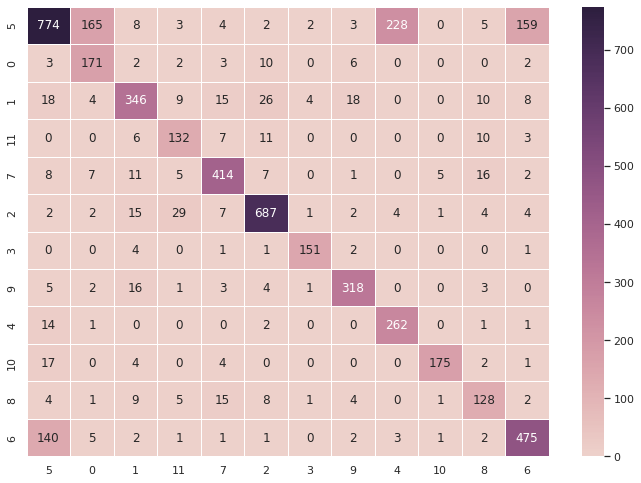

In [72]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
names = pd.unique(valid_labels)
cm = confusion_matrix(preds, valid_labels)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")
plt.show()

### TEST DATASET

In [57]:
predictions_test = trainer_maptask2.predict(test_dataset)

In [59]:
print(predictions_test.predictions.shape, predictions_test.label_ids.shape)


(5335, 31) (5335,)


In [62]:
preds_test = np.argmax(predictions_test.predictions, axis=-1)

In [63]:
print(classification_report(preds_test, test_labels))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1295
           1       0.59      0.90      0.71       181
           2       0.86      0.81      0.83       499
           3       0.72      0.90      0.80       211
           4       0.94      0.91      0.92       447
           5       0.95      0.92      0.94       874
           6       0.96      0.97      0.96       137
           7       0.93      0.92      0.92       359
           8       0.45      0.88      0.60       205
           9       0.95      0.83      0.89       219
          10       0.81      0.84      0.82       176
          11       0.83      0.71      0.76       732

    accuracy                           0.81      5335
   macro avg       0.81      0.85      0.82      5335
weighted avg       0.83      0.81      0.81      5335



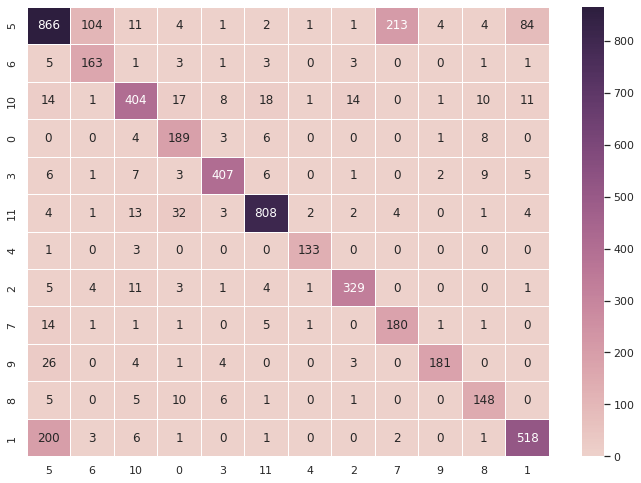

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
names = pd.unique(test_labels)
cm = confusion_matrix(preds_test, test_labels)
df_cm = pd.DataFrame(cm, index=names, columns=names)
# config plot sizes
sn.set(rc={'figure.figsize':(11.7,8.27)})
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, cmap=sn.cubehelix_palette(as_cmap=True), linewidth=0.5, fmt="")
plt.show()